In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

from mtj.init import init_m
from mtj.calc_Heff import calc_e
from mtj.calc_torque import calc_torque
from mtj.llg_heun import LLG_Heun_Heff
from mtj.constants import VACUUM_PERMEABILITY
from mtj.types import MaterialProps

### Demonstration of stable state computation

In this demonstration, we perform a simulation to determine the stable state of the same sample of the other notebook "usage-without-stt" (a thin film of soft magnetic material (Permalloy), with $m_S\approx1 \space \text{T}$, and a demagnetization tensor with $N_{xx}=N_{yy} = 0$ and $N_{zz}=1$), without thermal oscillations. Since we are only interested in the stable state, we increase the damping factor to shorten the simulation time and we run it until the condition $\frac{|M\times H_{eff}|}{M_s}<10^{-6}$ is satisfied. The total energy of the system normalized per unit volume is computed and plotted over time. The STT contribution is not considered here (otherwise, an additional term to the energy due to the STT contribution must be included, which we still inserted into the code but do not use now).

**Parameters Used**

| Constant | Symbol | Value | Unit | Description |
|----------|--------|-------|------|-------------|
| Saturation magnetization (Permalloy) | $M_s$ | $\approx 1$ | T | Typical for Permalloy |
| Magnetocrystalline anisotropy constant | $K_u$ | $5 \cdot 10^5$ | J/m³ | Example value for perpendicular anisotropy |
| Temperature | $T$ | 0 | K | Low temperature |
| Applied field | $H_{app}$ | $10^5$ | A/m | External field (in z direction only) |
| Volume (approx.) | $V$ | $7500$ | nm³ | Magnetic sample volume |
| Time step | $\Delta t$ | $10^{-13}$ | s | Simulation time step |
| Damping factor | $\alpha$ | 1 | (unitless) | Gilbert damping parameter |

In [2]:
max_count = 10000  # maximum number of iterations
threshold = 1e-6  # threshold for convergence


def calculate_magnetization(
    m0: npt.NDArray[
        np.float64
    ],  # Initial magnetization (is normalized before simulation)
    H_app=np.array([0, 0, 1e5]),  # A/m
    max_count=max_count,
    dt=1e-13,  # time step (s)
    alpha=1,  # Damping factor
    K_u=5e5,
    M_s=1 / VACUUM_PERMEABILITY,  # Default: NiFe permalloy Ms (A/m)
    u_k=np.array([0, 0, 1]),  # Shape anisotropy
    N=np.diag([0, 0, 1]),  # Default: "infinite" thin film
    T=0,  # Temperature (K) - H_th diabled if 0
    Vol=1.5e-9 * 40e-9**2 * np.pi,  # Volume
    Volt=0,  # STT voltage
    p=np.array([1, 0, 0]),  # STT polarizer orientation
    a_par=0,  # STT coefficients
    a_perp=0,
    stt_enable=False,
    recompute_H_th=False,
    recompute_H_eff=False,
):
    m = init_m(m0, max_count + 1)
    e = np.empty(max_count + 1)
    n = np.empty(max_count + 1)
    params: MaterialProps = {
        "K_u": K_u,
        "M_s": M_s,
        "u_k": u_k,
        "p": p,
        "a_para": a_par,
        "a_ortho": a_perp,
        "V": Volt,
        "H_app": H_app,
        "N": N,
    }

    c = 0
    e[0] = calc_e(m[0], stt_enable, **params)
    while True:
        # Calculate the magnetization for the next time step and the effective field term for the current step.
        m[c + 1], H_eff = LLG_Heun_Heff(
            m[c],
            T,
            Vol,
            dt,
            alpha,
            stt_enable=stt_enable,
            recompute_H_th=recompute_H_th,
            recompute_H_eff=recompute_H_eff,
            **params,
        )
        e[c + 1] = calc_e(m[c + 1], stt_enable, **params)
        n[c + 1] = calc_torque(m[c + 1], H_eff, M_s)
        c += 1
        if c >= max_count:
            print(f"Maximum number of iterations exceeded ({max_count}).")
            break
        if n[c] < threshold:
            print(
                f"Convergence condition reached (threshold = {threshold}) after {c} steps."
            )
            m = np.array(m[0 : c + 1, :])
            e = np.array(e[0 : c + 1])
            n = np.array(n[0 : c + 1])
            break

    time_series = np.arange(0, dt * len(m), dt)

    return m, e, n, time_series

Convergence condition reached (threshold = 1e-06) after 4210 steps.


Text(0.5, 0.98, 'Time evolution of magnetization and convergence performance indicators')

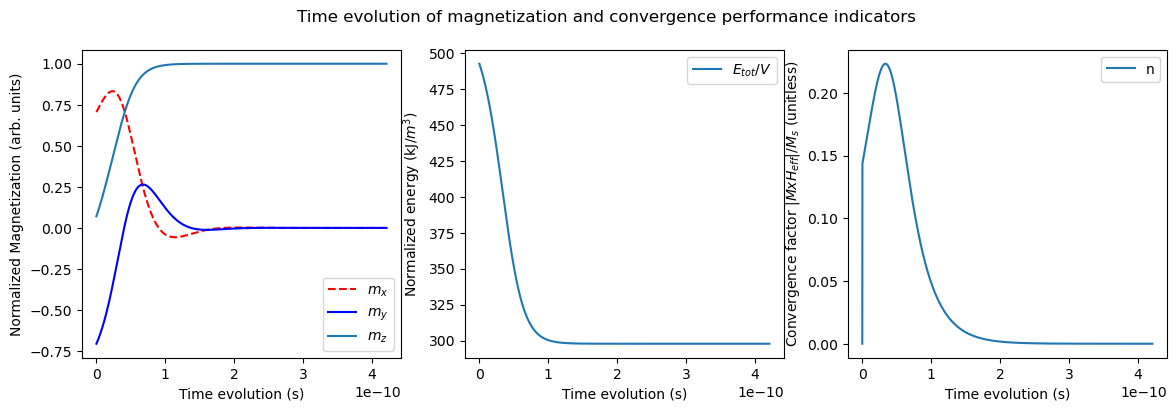

In [3]:
m, e, n, t = calculate_magnetization(m0=np.array([1, -1, 0.1]))

fig, ax = plt.subplots(1, 3, figsize=(14,4))
ax[0].plot(t, m[:, 0], "r--", label=r"$m_x$")
ax[0].plot(t, m[:, 1], "b", label=r"$m_y$")
ax[0].plot(t, m[:, 2], label=r"$m_z$")

ax[0].set_xlabel("Time evolution (s)")
ax[0].set_ylabel("Normalized Magnetization (arb. units)")
ax[0].legend()

ax[1].plot(t, e / 1000, label="$E_{tot}/V$")

ax[1].set_xlabel("Time evolution (s)")
ax[1].set_ylabel("Normalized energy (kJ/$m^3$)")
ax[1].ticklabel_format(style="sci")
ax[1].legend()

ax[2].plot(t, n, label="n")

ax[2].set_xlabel("Time evolution (s)")
ax[2].set_ylabel("Convergence factor $|MxH_{eff}|/M_s$ (unitless)")
ax[2].legend()

fig.suptitle("Time evolution of magnetization and convergence performance indicators")